## Setting up Environment and Function

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [04:09<00:00, 23.1MB/s]
100% 5.20G/5.20G [04:09<00:00, 22.4MB/s]


In [3]:
! mkdir data
! unzip -q skin-cancer-mnist-ham10000.zip -d data

In [4]:
! mkdir models

In [5]:
!cp -r data /content/drive/MyDrive/data
!cp -r models /content/drive/MyDrive/models

In [6]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as Fun
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from transformers import ViTModel, ViTFeatureExtractor, ViTForImageClassification, AdamW, get_linear_schedule_with_warmup


# Set Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")


Using device: cuda


In [7]:
# Constants
# change if required
#DATA_DIR = 'data/'
DATA_DIR = '/content/drive/MyDrive/data'

METADATA_FILE = os.path.join(DATA_DIR, 'HAM10000_metadata.csv')
IMAGE_DIRS = [os.path.join(DATA_DIR, 'HAM10000_images_part_1'),
              os.path.join(DATA_DIR, 'HAM10000_images_part_2')]


# Load Metadata
metadata = pd.read_csv(METADATA_FILE)
metadata.head()



,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [8]:
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"cuDNN Version: {torch.backends.cudnn.version()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Count: {torch.cuda.device_count()}")

PyTorch Version: 2.4.1+cu121
CUDA Available: True
CUDA Version: 12.1
cuDNN Version: 90100
GPU Name: NVIDIA A100-SXM4-40GB
GPU Count: 1


### StratifiedKFold


In [9]:
from itertools import product
from collections import defaultdict
import numpy as np

class customStratifiedKFold:
  def __init__(self, n_split, shuffle, random_state):
    self.n_split = n_split
    self.shuffle = shuffle
    self.random_state = random_state

  def split(self, X, y):
    if (self.shuffle and self.random_state) is not None:
      np.random.seed(self.random_state)

    idx = np.arange(len(y))
    if self.shuffle:
      np.random.shuffle(idx)

    y_idx = defaultdict(list)
    for i, label in zip(idx, y):
      y_idx[label].append(i)

    splits = [[] for _ in range(self.n_split)]

    for label, i in y_idx.items():
      np.random.shuffle(i)
      split_portions = [len(i) // self.n_split] * self.n_split
      for j in range(len(i) % self.n_split):
        split_portions[j] += 1

      first = 0
      for k in range(self.n_split):
        last = first + split_portions[k]
        splits[k].extend(i[first:last])
        first = last

    for i in range(self.n_split):
      test_idx = splits[i]
      train_idx = np.concatenate([splits[j] for j in range(self.n_split) if j != i])
      yield train_idx, test_idx

    def get_n_splits(self):
        return self.n_split

### Nested CrossVal

In [10]:
import os
import time
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import torch

def cross_validate(model_class, X, y, outer_splits=3, inner_splits=3, hypers=None, metadata_features=None, image_dirs=None, feature_extractor=None, transform_train=None, transform_val=None, device='cpu', log_file='cross_validation_log.txt'):
    outer_skf = customStratifiedKFold(n_split=outer_splits, shuffle=True, random_state=42)
    results = []

    total_combinations = outer_splits * inner_splits * len(hypers)
    pbar = tqdm(total=total_combinations + outer_splits, desc="Nested Cross-Validation Progress", unit="combo", mininterval=5.0)  # Update every 5 seconds

    with open(log_file, "w") as log:
        log.write("Cross-Validation Log\n")
        log.write("====================\n")

    for outer_fold, (train_val_idx, test_idx) in enumerate(outer_skf.split(X, y), 1):
        outer_start_time = time.time()
        X_train_val, X_test = X[train_val_idx], X[test_idx]
        y_train_val, y_test = y[train_val_idx], y[test_idx]

        inner_skf = customStratifiedKFold(n_split=inner_splits, shuffle=True, random_state=42)
        hyper_results = defaultdict(list)

        for inner_fold, (train_idx, val_idx) in enumerate(inner_skf.split(X_train_val, y_train_val), 1):
            X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
            y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

            for hyper in hypers:
                hyper_start_time = time.time()

                model = model_class(num_metadata_features=len(metadata_features),
                                    num_classes=len(np.unique(y)),
                                    **hyper).to(device)

                optimizer = torch.optim.AdamW(model.parameters(), lr=hyper['lr'])
                scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
                criterion = torch.nn.CrossEntropyLoss()

                train_dataset = SkinCancerDataset(metadata.iloc[train_idx], image_dirs, feature_extractor, metadata_features, transform=transform_train)
                val_dataset = SkinCancerDataset(metadata.iloc[val_idx], image_dirs, feature_extractor, metadata_features, transform=transform_val)

                train_loader = DataLoader(train_dataset, batch_size=hyper['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
                val_loader = DataLoader(val_dataset, batch_size=hyper['batch_size'], shuffle=False, num_workers=2, pin_memory=True)

                best_val_acc_inner = 0.0
                EPOCHS = hyper.get('epochs', 10)

                for epoch in range(EPOCHS):
                    train_loss, train_acc = train_epoch(
                        model=model,
                        dataloader=train_loader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        device=device,
                        loss_fn=criterion,
                        input_types=['image', 'metadata']
                    )

                    val_loss, val_acc = eval_epoch(
                        model=model,
                        dataloader=val_loader,
                        device=device,
                        loss_fn=criterion,
                        input_types=['image', 'metadata']
                    )

                    if val_acc > best_val_acc_inner:
                        best_val_acc_inner = val_acc

                hyper_results[frozenset(hyper.items())].append(best_val_acc_inner)

                # Update progress bar less frequently
                if inner_fold % 2 == 0:  # Update every 2 inner folds
                    pbar.update(1)
                    pbar.set_postfix({
                        'Outer Fold': outer_fold,
                        'Inner Fold': inner_fold,
                        'Val Acc': best_val_acc_inner
                    })

                with open(log_file, "a") as log:
                    log.write(f"Outer Fold: {outer_fold}, Inner Fold: {inner_fold}, Hyperparams: {hyper}, Val Acc: {best_val_acc_inner:.4f}, Time: {time.time() - hyper_start_time:.2f}s\n")

        # Calculate average validation accuracy for each hyperparameter set
        avg_hyper_results = {k: np.mean(v) for k, v in hyper_results.items()}

        # Find the best hyperparameters based on the average validation accuracy
        best_hyperparams = max(avg_hyper_results, key=avg_hyper_results.get)

        # Convert the best hyperparameters from frozenset to dict for readability
        best_hyperparams_dict = dict(best_hyperparams)

        # Use best_hyperparams_dict for logging or further processing
        best_score = avg_hyper_results[best_hyperparams]

        results.append((best_hyperparams, best_score))

        pbar.update(1)
        pbar.set_postfix({
            'Outer Fold': outer_fold,
            'Status': 'Completed',
            'Best Val Acc': best_score
        })

        with open(log_file, "a") as log:
            log.write(f"Outer Fold {outer_fold} completed in {time.time() - outer_start_time:.2f}s\n")
            log.write("--------------------------------------------------\n")

        print(f"Fold {outer_fold}: Best Params: {best_hyperparams}, Best Val Accuracy: {best_score:.2f}")

    pbar.close()
    return results

## Fusion Models: Training with Both Modalities


### Data Preparation


In [11]:
# Data Cleaning and Encoding for Metadata
metadata['age'].fillna(metadata['age'].median(), inplace=True)
metadata['sex'].fillna('unknown', inplace=True)
metadata['localization'].fillna('unknown', inplace=True)

# Encoding Categorical Features
le_dx = LabelEncoder()
metadata['dx_encoded'] = le_dx.fit_transform(metadata['dx'])

le_sex = LabelEncoder()
metadata['sex_encoded'] = le_sex.fit_transform(metadata['sex'])

le_loc = LabelEncoder()
metadata['localization_encoded'] = le_loc.fit_transform(metadata['localization'])

# Normalize Numerical Features
scaler = StandardScaler()
metadata['age'] = scaler.fit_transform(metadata[['age']])

# Define Feature Columns
metadata_features = ['age', 'sex_encoded', 'localization_encoded']

# Define Number of Classes
num_classes = len(le_dx.classes_)
print(f"Number of classes: {num_classes}")
print(le_dx.classes_)

Number of classes: 7
['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


<ipython-input-11-a722c2e35ae2>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metadata['age'].fillna(metadata['age'].median(), inplace=True)
<ipython-input-11-a722c2e35ae2>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [12]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_encoded,sex_encoded,localization_encoded
0,HAM_0000118,ISIC_0027419,bkl,histo,1.663522,male,scalp,2,1,11
1,HAM_0000118,ISIC_0025030,bkl,histo,1.663522,male,scalp,2,1,11
2,HAM_0002730,ISIC_0026769,bkl,histo,1.663522,male,scalp,2,1,11
3,HAM_0002730,ISIC_0025661,bkl,histo,1.663522,male,scalp,2,1,11
4,HAM_0001466,ISIC_0031633,bkl,histo,1.368014,male,ear,2,1,4


### Dataset Class (output both metadata and image)


In [13]:
class SkinCancerDataset(Dataset):
    """
      A custom PyTorch Dataset for handling multimodal data consisting of images and metadata for skin cancer classification.

      Attributes:
          dataframe (pd.DataFrame): DataFrame containing metadata and labels for the dataset.
          image_dirs (list): List of directories where images are stored.
          feature_extractor (ViTFeatureExtractor): Feature extractor for processing images.
          transform (callable, optional): Optional transform to be applied on an image.
          metadata_features (list): List of metadata feature column names to be used.

      Methods:
          __init__(dataframe, image_dirs, feature_extractor, metadata_features, transform=None):
              Initializes the dataset with the given parameters.

          __len__():
              Returns the number of samples in the dataset.

          __getitem__(idx):
              Retrieves the image, metadata, and label for a given index.
    """
    def __init__(self, dataframe, image_dirs, feature_extractor, metadata_features, transform=None):
        """
        Initializes the SkinCancerMultimodalDataset.
        """
        self.dataframe = dataframe
        self.image_dirs = image_dirs
        self.feature_extractor = feature_extractor
        self.transform = transform
        self.metadata_features = metadata_features

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Retrieves the image, metadata, and label for a given index.
        """
        row = self.dataframe.iloc[idx]
        image_id = row['image_id']
        # Search for the image in the provided directories
        for directory in self.image_dirs:
            image_path = os.path.join(directory, f"{image_id}.jpg")
            if os.path.exists(image_path):
                break
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        metadata = torch.tensor(row[self.metadata_features].values.astype(np.float32))
        label = torch.tensor(row['dx_encoded'])
        return image, metadata, label

### Transform Pipeline

In [14]:
# Initialize Feature Extractor
MODEL_NAME = 'google/vit-base-patch32-224-in21k'  # ViT-B_32
feature_extractor = ViTFeatureExtractor.from_pretrained(MODEL_NAME)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


### Creating Multimodal Datasets and DataLoaders

In [15]:
# Split Data into Train, Validation, and Test Sets (from scratch)

X = metadata.drop(columns=['dx_encoded']).values  # Features
y = metadata['dx_encoded'].values  # Labels

# Instantiate the stratifiedKFold class for the outer split
outer_skf = customStratifiedKFold(n_split=5, shuffle=True, random_state=42)

# Get the first fold as the test set
for fold, (train_val_idx, test_idx) in enumerate(outer_skf.split(X, y)):
    if fold == 0:  # Use the first fold as the test set
        X_train_val, X_test = X[train_val_idx], X[test_idx]
        y_train_val, y_test = y[train_val_idx], y[test_idx]
        break

# Instantiate the stratifiedKFold class for the inner split
inner_skf = customStratifiedKFold(n_split=10, shuffle=True, random_state=42)

# Get the first fold as the validation set
for fold, (train_idx, val_idx) in enumerate(inner_skf.split(X_train_val, y_train_val)):
    if fold == 0:  # Use the first fold as the validation set
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]
        break

# Convert indices back to DataFrames
train_df = metadata.iloc[train_val_idx[train_idx]]
val_df = metadata.iloc[train_val_idx[val_idx]]
test_df = metadata.iloc[test_idx]

# Print the number of samples in each set
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

Training samples: 7206
Validation samples: 804
Testing samples: 2005


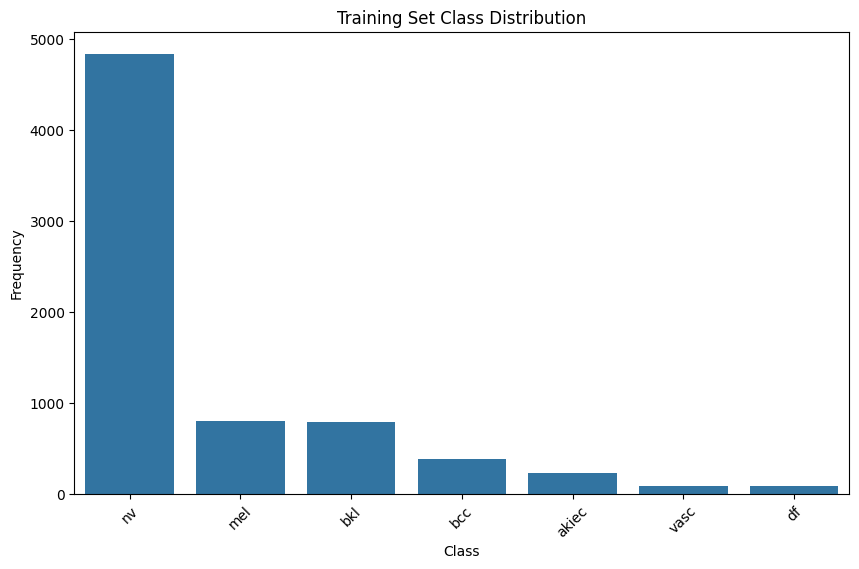

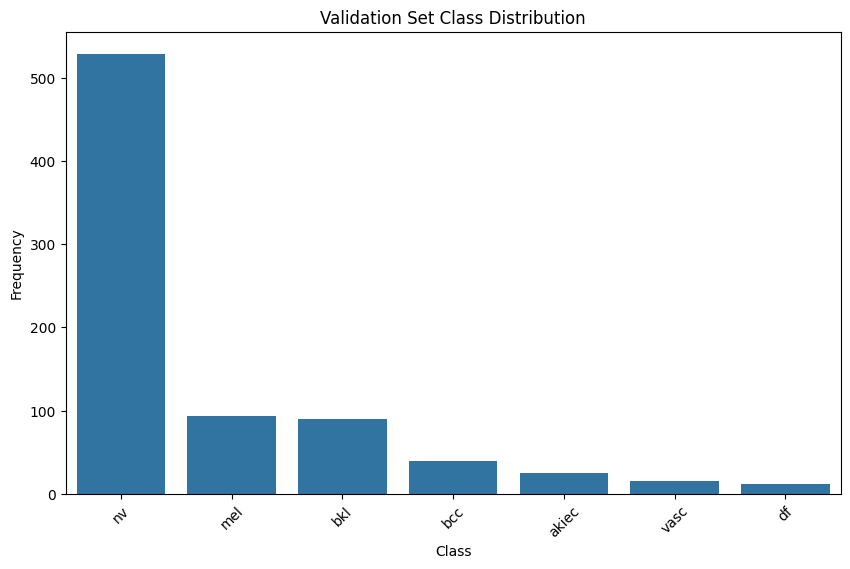

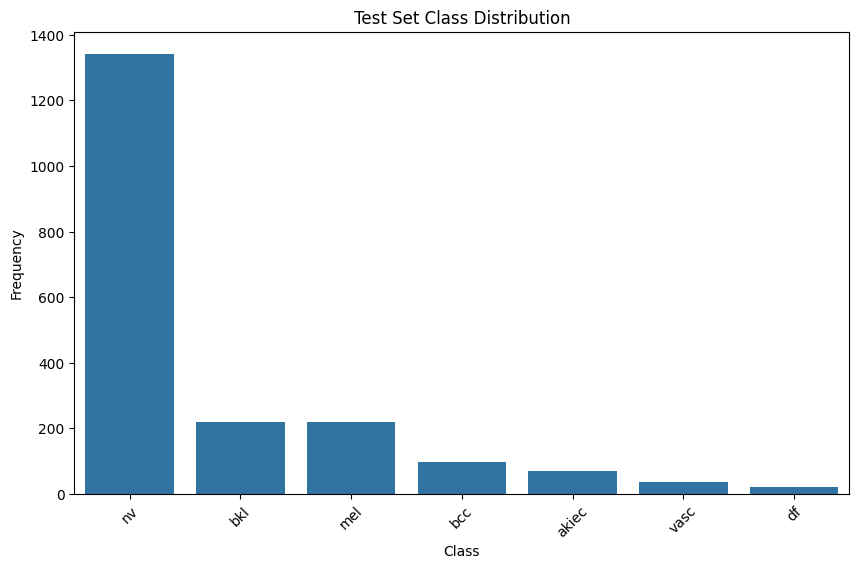

In [16]:
def plot_class_distribution(df, label_column, title):
    """
    Plots the class distribution of a given DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        label_column (str): The column name for class labels.
        title (str): The title for the plot.
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(x=label_column, data=df, order=df[label_column].value_counts().index)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)  # Rotate class labels for better readability if needed
    plt.show()

# Plot class distribution for each set using the class label column
plot_class_distribution(train_df, 'dx', 'Training Set Class Distribution')
plot_class_distribution(val_df, 'dx', 'Validation Set Class Distribution')
plot_class_distribution(test_df, 'dx', 'Test Set Class Distribution')

In [17]:
# Get class counts for the training, validation, and test sets
_, train_class_counts = np.unique(y_train, return_counts=True)
_, val_class_counts = np.unique(y_val, return_counts=True)
_, test_class_counts = np.unique(y_test, return_counts=True)

# Store class counts in lists
train_class_counts_list = list(train_class_counts)
val_class_counts_list = list(val_class_counts)
test_class_counts_list = list(test_class_counts)

# Print class counts for each set
print(f"Training set class counts: {train_class_counts_list}")
print(f"Validation set class counts: {val_class_counts_list}")
print(f"Test set class counts: {test_class_counts_list}")

Training set class counts: [231, 378, 790, 83, 800, 4834, 90]
Validation set class counts: [25, 39, 90, 12, 94, 529, 15]
Test set class counts: [71, 97, 219, 20, 219, 1342, 37]


In [18]:
# Creating Multimodal Datasets and DataLoaders
train_dataset = SkinCancerDataset(train_df, IMAGE_DIRS, feature_extractor, metadata_features, transform=train_transform)
val_dataset = SkinCancerDataset(val_df, IMAGE_DIRS, feature_extractor, metadata_features, transform=val_test_transform)
test_dataset = SkinCancerDataset(test_df, IMAGE_DIRS, feature_extractor, metadata_features, transform=val_test_transform)

BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True) #worker = 4 if A100
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of testing batches: {len(test_loader)}")


Number of training batches: 57
Number of validation batches: 7
Number of testing batches: 16


### Train/Eval Loop

In [19]:
def train_epoch(model, dataloader, optimizer, scheduler, device, loss_fn, input_types=['image']):
    """
    Trains a model for one epoch, handling various input types.

    Args:
        model (nn.Module): The neural network model to train.
        dataloader (DataLoader): DataLoader for the training data.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        scheduler (torch.optim.lr_scheduler): Learning rate scheduler.
        device (torch.device): Device to perform training on (CPU or GPU).
        loss_fn (nn.Module): Loss function, e.g., CrossEntropyLoss.
        input_types (list): List specifying the types of inputs the model expects (e.g., ['image'], ['image', 'metadata']).

    Returns:
        tuple: (epoch_loss, epoch_acc)
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, data in enumerate(tqdm(dataloader, desc="Training",mininterval=5.0)):
        # Unpack and move data to device
        if 'metadata' in input_types:
            images, metadata, labels = data
            images = images.to(device)
            metadata = metadata.to(device)
        else:
            images, labels = data
            images = images.to(device)

        labels = labels.to(device)

        '''
        # Verify devices
        if batch_idx == 0:
            if 'metadata' in input_types:
                print(f"\nImages are on device: {images.device}")
                print(f"Metadata are on device: {metadata.device}")
            else:
                print(f"Images are on device: {images.device}")
            print(f"Labels are on device: {labels.device}")
            print(f"Model is on device: {next(model.parameters()).device}")
        '''
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        if 'metadata' in input_types:
            outputs = model(images, metadata)
        else:
            outputs = model(images)

        # Compute loss
        if hasattr(outputs, 'loss'):
            loss = outputs.loss
            logits = outputs.logits
        else:
            logits = outputs
            loss = loss_fn(logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Accumulate loss and accuracy
        running_loss += loss.item() * labels.size(0)
        _, preds = torch.max(logits, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def eval_epoch(model, dataloader, device, loss_fn, input_types=['image']):
    """
    Evaluates a model on a validation or test set, handling various input types.

    Args:
        model (nn.Module): The neural network model to evaluate.
        dataloader (DataLoader): DataLoader for the evaluation data.
        device (torch.device): Device to perform evaluation on (CPU or GPU).
        loss_fn (nn.Module): Loss function, e.g., CrossEntropyLoss.
        input_types (list): List specifying the types of inputs the model expects (e.g., ['image'], ['image', 'metadata']).

    Returns:
        tuple: (epoch_loss, epoch_acc)
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, data in enumerate(tqdm(dataloader, desc="Evaluating",mininterval=5.0)):

            # Unpack and move data to device
            if 'metadata' in input_types:
                images, metadata, labels = data
                images = images.to(device)
                metadata = metadata.to(device)
            else:
                images, labels = data
                images = images.to(device)

            labels = labels.to(device)
            '''
            # Verify devices
            if batch_idx == 0:
                if 'metadata' in input_types:
                    print(f"\nImages are on device: {images.device}")
                    print(f"Metadata are on device: {metadata.device}")
                else:
                    print(f"Images are on device: {images.device}")
                print(f"Labels are on device: {labels.device}")
                print(f"Model is on device: {next(model.parameters()).device}")
            '''
            # Forward pass

            if 'metadata' in input_types:
                outputs = model(images, metadata)
            else:
                outputs = model(images)

            # Compute loss
            if hasattr(outputs, 'loss'):
                loss = outputs.loss  # For models like ViTForImageClassification
                logits = outputs.logits
            else:
                logits = outputs  # For custom models
                loss = loss_fn(logits, labels)

            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(logits, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


### Early Fusion Model (Feature-Level Fusion)

In [20]:
# Implementation

class EarlyFusionModel(nn.Module):
    """
      A neural network model for early fusion of image and metadata features using a Vision Transformer (ViT).

      Attributes:
          vit (ViTModel): Pretrained Vision Transformer model for extracting image features.
          metadata_fc (nn.Linear): Fully connected layer for processing metadata features.
          classifier (nn.Linear): Fully connected layer for classification based on combined features.
          dropout (nn.Dropout): Dropout layer for regularization.

      Methods:
          __init__(num_metadata_features, num_classes, pretrained_model_name='google/vit-base-patch32-224-in21k'):
              Initializes the EarlyFusionModel with specified parameters.

          forward(image, metadata):
              Performs a forward pass through the model, combining image and metadata features for classification.
    """
    def __init__(self, num_metadata_features, num_classes, lr = 1e-5, epochs = 10, batch_size = 64, pretrained_model_name='google/vit-base-patch32-224-in21k'):
        super(EarlyFusionModel, self).__init__()
        self.vit = ViTModel.from_pretrained(pretrained_model_name)
        vit_hidden_size = self.vit.config.hidden_size # Final hidden layer size for ViT is 768 typically.
        self.metadata_fc = nn.Linear(num_metadata_features, 128) # Pass metadata to fully-connected (FC) layer in the NN.
        self.classifier = nn.Linear(vit_hidden_size + 128, num_classes) # Pass fused feature to FC layer for classification.

        #Hyperparam
        self.dropout = nn.Dropout(0.1)
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size

    def set_params(self, **params):
        for param, value in params.items():
            if hasattr(self, param):
                setattr(self, param, value)
            else:
                raise ValueError(f"Parameter {param} is not valid for this model.")

    def forward(self, image, metadata):
        vit_outputs = self.vit(image)
        image_features = vit_outputs.last_hidden_state[:, 0, :]  # CLS token from final hidden state (usual size is )
        metadata_features = self.metadata_fc(metadata)
        metadata_features = torch.relu(metadata_features)
        combined_features = torch.cat((image_features, metadata_features), dim=1)
        combined_features = self.dropout(combined_features)
        logits = self.classifier(combined_features)
        return logits


# Integration

# Initialize Early Fusion Model
num_metadata_features = len(metadata_features)
model_early_fusion = EarlyFusionModel(num_metadata_features=num_metadata_features, num_classes=num_classes)
model_early_fusion.to(DEVICE)

# Define Optimizer and Scheduler
EPOCHS = 10 # epoch to adjust
optimizer_early = AdamW(model_early_fusion.parameters(), lr=1e-5) # learning rate to adjust
scheduler_early = get_linear_schedule_with_warmup(
    optimizer_early,
    num_warmup_steps=int(0.1 * len(train_loader) * EPOCHS),
    num_training_steps=len(train_loader) * EPOCHS
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Weighted class distribution
class_counts_tensor = torch.tensor(train_class_counts_list, dtype=torch.float32)
class_weights = 1.0 / class_counts_tensor  # Inverse of class counts
class_weights = class_weights / class_weights.sum()  # Normalize (optional)
class_weights = class_weights.to(DEVICE)  # Move to the appropriate device

# Define the train loss function
criterion_train = nn.CrossEntropyLoss(weight=class_weights)

# Define the eval loss function
criterion_eval = nn.CrossEntropyLoss()

# Training Loop
best_val_acc = 0.0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 10)

    # Training Phase
    train_loss, train_acc = train_epoch(
        model=model_early_fusion,
        dataloader=train_loader,
        optimizer=optimizer_early,
        scheduler=scheduler_early,
        device=DEVICE,
        loss_fn=criterion_train,
        input_types=['image', 'metadata']
    )

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%\n")

    # Evaluation Phase
    val_loss, val_acc = eval_epoch(
        model=model_early_fusion,
        dataloader=val_loader,
        device=DEVICE,
        loss_fn=criterion_eval,
        input_types=['image', 'metadata']
    )

    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    # Checkpointing
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        os.makedirs('models/early_fusion', exist_ok=True)
        torch.save(model_early_fusion.state_dict(), 'models/early_fusion/best_model.pth')
        print("Model checkpoint saved.")


Epoch 1/15
----------


Training: 100%|██████████| 57/57 [00:38<00:00,  1.47it/s]


Train Loss: 1.9844 | Train Acc: 10.20%



Evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Val Loss: 1.9548 | Val Acc: 14.18%
Model checkpoint saved.

Epoch 2/15
----------


Training: 100%|██████████| 57/57 [00:39<00:00,  1.45it/s]


Train Loss: 1.8457 | Train Acc: 37.95%



Evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Val Loss: 1.7685 | Val Acc: 45.90%
Model checkpoint saved.

Epoch 3/15
----------


Training: 100%|██████████| 57/57 [00:39<00:00,  1.45it/s]


Train Loss: 1.6278 | Train Acc: 58.44%



Evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Val Loss: 1.6123 | Val Acc: 54.60%
Model checkpoint saved.

Epoch 4/15
----------


Training: 100%|██████████| 57/57 [00:38<00:00,  1.47it/s]


Train Loss: 1.3973 | Train Acc: 64.45%



Evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Val Loss: 1.3758 | Val Acc: 62.19%
Model checkpoint saved.

Epoch 5/15
----------


Training: 100%|██████████| 57/57 [00:39<00:00,  1.44it/s]


Train Loss: 1.2265 | Train Acc: 66.92%



Evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Val Loss: 1.3055 | Val Acc: 63.43%
Model checkpoint saved.

Epoch 6/15
----------


Training: 100%|██████████| 57/57 [00:39<00:00,  1.45it/s]


Train Loss: 1.1046 | Train Acc: 68.82%



Evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Val Loss: 1.2034 | Val Acc: 65.05%
Model checkpoint saved.

Epoch 7/15
----------


Training: 100%|██████████| 57/57 [00:39<00:00,  1.45it/s]


Train Loss: 1.0184 | Train Acc: 69.48%



Evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Val Loss: 1.1582 | Val Acc: 67.04%
Model checkpoint saved.

Epoch 8/15
----------


Training: 100%|██████████| 57/57 [00:39<00:00,  1.45it/s]


Train Loss: 0.9569 | Train Acc: 70.91%



Evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Val Loss: 1.0893 | Val Acc: 67.29%
Model checkpoint saved.

Epoch 9/15
----------


Training: 100%|██████████| 57/57 [00:39<00:00,  1.44it/s]


Train Loss: 0.8953 | Train Acc: 71.68%



Evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Val Loss: 1.0618 | Val Acc: 68.16%
Model checkpoint saved.

Epoch 10/15
----------


Training: 100%|██████████| 57/57 [00:38<00:00,  1.46it/s]


Train Loss: 0.8530 | Train Acc: 72.20%



Evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Val Loss: 1.0398 | Val Acc: 68.03%

Epoch 11/15
----------


Training: 100%|██████████| 57/57 [00:39<00:00,  1.44it/s]


Train Loss: 0.8188 | Train Acc: 72.80%



Evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Val Loss: 0.9904 | Val Acc: 71.02%
Model checkpoint saved.

Epoch 12/15
----------


Training: 100%|██████████| 57/57 [00:39<00:00,  1.45it/s]


Train Loss: 0.7886 | Train Acc: 73.52%



Evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Val Loss: 1.0193 | Val Acc: 68.16%

Epoch 13/15
----------


Training: 100%|██████████| 57/57 [00:39<00:00,  1.45it/s]


Train Loss: 0.7692 | Train Acc: 74.08%



Evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Val Loss: 0.9882 | Val Acc: 69.53%

Epoch 14/15
----------


Training: 100%|██████████| 57/57 [00:39<00:00,  1.45it/s]


Train Loss: 0.7568 | Train Acc: 74.17%



Evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Val Loss: 0.9866 | Val Acc: 69.28%

Epoch 15/15
----------


Training: 100%|██████████| 57/57 [00:39<00:00,  1.46it/s]


Train Loss: 0.7504 | Train Acc: 74.17%



Evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

Val Loss: 0.9879 | Val Acc: 69.15%


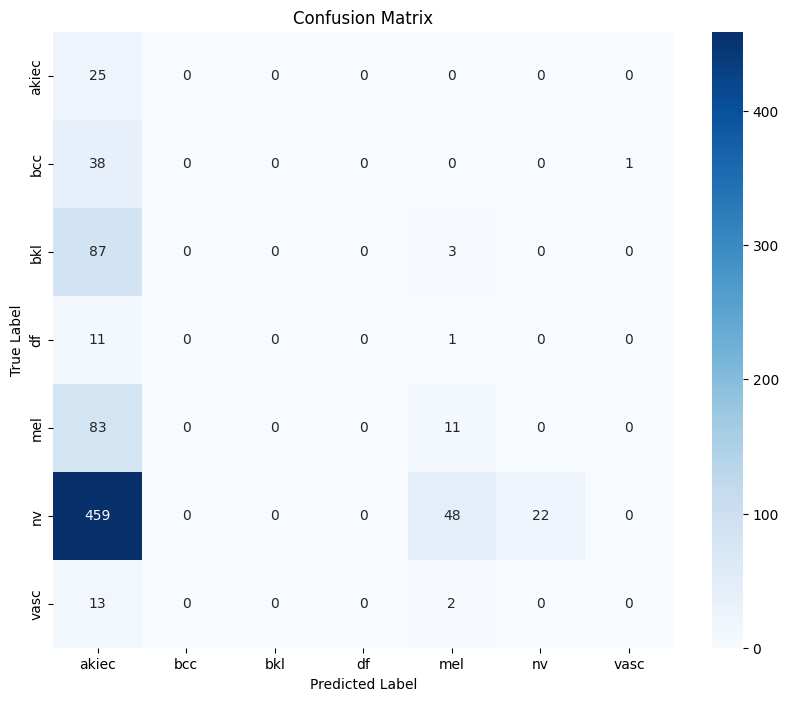

In [ ]:
def plot_confusion_matrix(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, metadata, labels in dataloader:
            images = images.to(device)
            metadata = metadata.to(device)
            labels = labels.to(device)

            outputs = model(images, metadata)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

plot_confusion_matrix(model_early_fusion, val_loader, DEVICE, class_names)

##### Nested CV (HyperParamTune)

In [ ]:
# Define hyperparameters to tune
hypers = [
    {'lr': 1e-4, 'epochs': 15, 'batch_size': 256}, #Conservative (Stable Learning)
    {'lr': 1e-3, 'epochs': 10, 'batch_size': 1024}, #Aggressive (Fast Learning):
    {'lr': 5e-5, 'epochs': 20, 'batch_size': 512}, #Middle-Ground (Balance Exploration/Exploitation):
    {'lr': 1e-5, 'epochs': 20, 'batch_size': 128} #Exploratory (Lower Learning Rate, More Epochs):
]

# Initialize the custom stratified K-Fold for splitting 20% of the data for hyperparameter tuning
tuning_kfold = customStratifiedKFold(n_split=5, shuffle=True, random_state=42)

# Split the data: 80% for independent CV, 20% for hyperparameter tuning
# We'll manually select 20% of the data based on stratified K-Fold
# Assuming the first split is used for hyperparameter tuning
splits = list(tuning_kfold.split(X, y))
train_main_idx, test_tuning_idx = splits[0]

X_tuning = X[test_tuning_idx]
y_tuning = y[test_tuning_idx]

# Perform nested cross-validation on the tuning set
nested_results = cross_validate(
    model_class=EarlyFusionModel,
    X=X_tuning,
    y=y_tuning,
    outer_splits=5,
    inner_splits=3,
    hypers=hypers,
    metadata_features=metadata_features,
    image_dirs=IMAGE_DIRS,
    feature_extractor=feature_extractor,
    transform_train=train_transform,
    transform_val=val_test_transform,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    log_file='hyperparameter_tuning_log.txt'
)

# Assuming nested_results is populated with tuples of (params, score)
nested_results = cross_validate(
    model_class=EarlyFusionModel,
    X=X_tuning,
    y=y_tuning,
    outer_splits=5,
    inner_splits=3,
    hypers=hypers,
    metadata_features=metadata_features,
    image_dirs=IMAGE_DIRS,
    feature_extractor=feature_extractor,
    transform_train=train_transform,
    transform_val=val_test_transform,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    log_file='hyperparameter_tuning_log.txt'
)

# After aggregating the results
avg_hyper_results = {}
for params, score in nested_results:
    # Convert frozenset to a dictionary
    params_dict = dict(params)
    # Create a sorted tuple of the dictionary items to use as a key
    params_tuple = tuple(sorted(params_dict.items()))
    avg_hyper_results[params_tuple] = avg_hyper_results.get(params_tuple, 0) + score

# Solution 1: Keep as tuples
avg_hyper_results = {k: v / 5 for k, v in avg_hyper_results.items()}

# Now, to find the best hyperparameters
# Convert tuple back to dict for readability when printing
best_hyperparams_tuple = max(avg_hyper_results, key=avg_hyper_results.get)
best_hyperparams_dict = dict(best_hyperparams_tuple)
best_score = avg_hyper_results[best_hyperparams_tuple]
print(f"Best Hyperparameters from Nested CV: {best_hyperparams_dict}")
print(f"Best Average Validation Accuracy: {best_score:.4f}")



Nested Cross-Validation Progress:   0%|          | 0/65 [00:00<?, ?combo/s]


Training:   0%|          | 0/5 [00:00<?, ?it/s]


Training: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]



Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]



Training:   0%|          | 0/5 [00:00<?, ?it/s]


Training: 100%|██████████| 5/5 [00:06<00:00,  1.33s/it]



Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]



Training:   0%|          | 0/5 [00:00<?, ?it/s]


Training: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]



Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]



Training:   0%|          | 0/5 [00:00<?, ?it/s]


Training: 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]



Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]



Training:   0%|          | 0/5 [00:00<?, ?it/s]


Training: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]



Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]



Training:   0%|          | 0/5 [00:00<?, ?it/s]


Training: 100%|█████

Fold 1: Best Params: frozenset({('batch_size', 1024), ('epochs', 10), ('lr', 0.001)}), Best Val Accuracy: 0.69


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


Nested Cross-Validation Progress:   9%|▉         | 6/65 [55:07<10:27:03, 637.69s/combo, Outer Fold=1, Status=Completed, Best Val Acc=0.688]

Evaluating: 100%|██████████| 1/1 [00:05<00:00,  5.81s/it]


Nested Cross-Validation Progress:  11%|█         | 7/65 [58:20<7:55:50, 492.24s/combo, Outer Fold=2, Inner Fold=2, Val Acc=0.673] 

Evaluating: 100%|██████████| 2/2 [00:05<00:00,  2.78s/it]


Nested Cross-Validation Progress:  12%|█▏        | 8/65 [1:02:47<6:39:27, 420.48s/combo, Outer Fold=2, Inner Fold=2, Val Acc=0.705]

Evaluating: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Nested Cross-Validation Progress:  14%|█▍        | 9/65 [1:05:49<5:22:52, 345.94s/combo, Outer Fold=2, Inner Fold=2, Val Acc=0.673]

Evaluating: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Nested Cross-Validation Progress:  15%|█▌        | 10/65 [1:18:59<7:22:44, 483.00s/combo, Outer Fold=2, Inner Fold=2, Val Acc=0.673]

Nested Cross-Validation Pro

Fold 2: Best Params: frozenset({('batch_size', 1024), ('epochs', 10), ('lr', 0.001)}), Best Val Accuracy: 0.70


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Nested Cross-Validation Progress:  17%|█▋        | 11/65 [1:34:42<9:21:24, 623.78s/combo, Outer Fold=2, Status=Completed, Best Val Acc=0.699]

Evaluating: 100%|██████████| 1/1 [00:05<00:00,  5.85s/it]


Nested Cross-Validation Progress:  18%|█▊        | 12/65 [1:37:56<7:15:25, 492.93s/combo, Outer Fold=3, Inner Fold=2, Val Acc=0.692]

Evaluating: 100%|██████████| 2/2 [00:05<00:00,  2.78s/it]


Nested Cross-Validation Progress:  20%|██        | 13/65 [1:42:23<6:07:53, 424.49s/combo, Outer Fold=3, Inner Fold=2, Val Acc=0.69]

Evaluating: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Nested Cross-Validation Progress:  22%|██▏       | 14/65 [1:45:25<4:58:46, 351.51s/combo, Outer Fold=3, Inner Fold=2, Val Acc=0.692]

Evaluating: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Nested Cross-Validation Progress:  23%|██▎       | 15/65 [1:58:37<6:43:26, 484.14s/combo, Outer Fold=3, Inner Fold=2, Val Acc=0.6]

Nested Cross-Validation 

Fold 3: Best Params: frozenset({('epochs', 15), ('lr', 0.0001), ('batch_size', 256)}), Best Val Accuracy: 0.68


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Nested Cross-Validation Progress:  25%|██▍       | 16/65 [2:14:20<8:28:04, 622.12s/combo, Outer Fold=3, Status=Completed, Best Val Acc=0.682]

Evaluating: 100%|██████████| 1/1 [00:05<00:00,  5.75s/it]


Nested Cross-Validation Progress:  26%|██▌       | 17/65 [2:17:32<6:34:25, 493.02s/combo, Outer Fold=4, Inner Fold=2, Val Acc=0.715]

Evaluating: 100%|██████████| 2/2 [00:05<00:00,  2.82s/it]


Nested Cross-Validation Progress:  28%|██▊       | 18/65 [2:22:00<5:33:13, 425.38s/combo, Outer Fold=4, Inner Fold=2, Val Acc=0.71]

Evaluating: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Nested Cross-Validation Progress:  29%|██▉       | 19/65 [2:25:04<4:30:30, 352.84s/combo, Outer Fold=4, Inner Fold=2, Val Acc=0.71]

Evaluating: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Nested Cross-Validation Progress:  31%|███       | 20/65 [2:38:25<6:05:27, 487.28s/combo, Outer Fold=4, Inner Fold=2, Val Acc=0.708]

Nested Cross-Validation

Fold 4: Best Params: frozenset({('lr', 5e-05), ('epochs', 20), ('batch_size', 512)}), Best Val Accuracy: 0.69


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Nested Cross-Validation Progress:  32%|███▏      | 21/65 [2:54:16<7:39:30, 626.60s/combo, Outer Fold=4, Status=Completed, Best Val Acc=0.686]

Evaluating: 100%|██████████| 1/1 [00:06<00:00,  6.03s/it]


Nested Cross-Validation Progress:  34%|███▍      | 22/65 [2:57:31<5:56:10, 496.98s/combo, Outer Fold=5, Inner Fold=2, Val Acc=0.675]

Evaluating: 100%|██████████| 2/2 [00:05<00:00,  2.81s/it]


Nested Cross-Validation Progress:  35%|███▌      | 23/65 [3:02:00<5:00:07, 428.74s/combo, Outer Fold=5, Inner Fold=2, Val Acc=0.694]

Evaluating: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Nested Cross-Validation Progress:  37%|███▋      | 24/65 [3:05:06<4:03:02, 355.67s/combo, Outer Fold=5, Inner Fold=2, Val Acc=0.683]

Evaluating: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Nested Cross-Validation Progress:  38%|███▊      | 25/65 [3:18:21<5:25:08, 487.72s/combo, Outer Fold=5, Inner Fold=2, Val Acc=0.147]

Nested Cross-Validati

Fold 5: Best Params: frozenset({('batch_size', 1024), ('epochs', 10), ('lr', 0.001)}), Best Val Accuracy: 0.68


Nested Cross-Validation Progress:   0%|          | 0/65 [00:00<?, ?combo/s]

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<0

Fold 1: Best Params: frozenset({('epochs', 15), ('lr', 0.0001), ('batch_size', 256)}), Best Val Accuracy: 0.69




Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it

Fold 2: Best Params: frozenset({('batch_size', 1024), ('epochs', 10), ('lr', 0.001)}), Best Val Accuracy: 0.68




Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it

Fold 3: Best Params: frozenset({('batch_size', 1024), ('epochs', 10), ('lr', 0.001)}), Best Val Accuracy: 0.68




Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it

Fold 4: Best Params: frozenset({('batch_size', 1024), ('epochs', 10), ('lr', 0.001)}), Best Val Accuracy: 0.70




Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


Evaluating: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it

Fold 5: Best Params: frozenset({('batch_size', 1024), ('epochs', 10), ('lr', 0.001)}), Best Val Accuracy: 0.69
Best Hyperparameters from Nested CV: {'batch_size': 1024, 'epochs': 10, 'lr': 0.001}
Best Average Validation Accuracy: 0.5500


#### Independent 20-fold CV

In [ ]:
import os
import pickle
import torch.optim as optim

# Constants for saving models
RESULT_SAVE_DIR = 'drive/MyDrive/fusion_Result'
MODEL_SAVE_DIR = 'drive/MyDrive/fusion_Model'
INDICES_SAVE_PATH = 'drive/MyDrive/fusion_indices.pkl'

best_params = {'lr': 5e-5}

# Configurable hyperparameters
EPOCHS = 20
BATCH_SIZE = 512
PATIENCE = 10

# Create a training function for each fold
def train_model(X_train, y_train, X_test, y_test, device, params, fold):
    model = EarlyFusionModel(
        num_metadata_features=len(metadata_features),
        num_classes=len(set(y_train)),
        lr=params['lr'],
        epochs=params.get('epochs', EPOCHS),
        batch_size=params.get('batch_size', BATCH_SIZE)
    )
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=params['lr'])
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    train_dataset = SkinCancerDataset(X_train, IMAGE_DIRS, feature_extractor, metadata_features, transform=train_transform)
    test_dataset = SkinCancerDataset(X_test, IMAGE_DIRS, feature_extractor, metadata_features, transform=val_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    best_val_acc = 0
    patience_counter = 0

    # Training loop
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for images, metadata, labels in train_loader:
            images = images.to(device)
            metadata = metadata.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, metadata)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct / total

        # Validation step
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, metadata, labels in test_loader:
                images = images.to(device)
                metadata = metadata.to(device)
                labels = labels.to(device)
                outputs = model(images, metadata)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total

        # Print epoch progress
        print(f"Fold {fold+1}, Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")



        # Early stopping logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

    # After training, evaluate on the test fold and save predictions
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for images, metadata, labels in test_loader:
            images = images.to(device)
            metadata = metadata.to(device)
            outputs = model(images, metadata)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    # Save test results to a CSV file
    test_result_df = pd.DataFrame({
        'Prediction': predictions,
        'Actual': actuals
    })
    test_file_name = f"{RESULT_SAVE_DIR}/fold{fold+1}_test.csv"
    test_result_df.to_csv(test_file_name, index=False)
    print(f"Fold {fold+1} test predictions saved to {test_file_name}")

    # Evaluate on the training fold and save predictions
    train_predictions = []
    train_actuals = []
    with torch.no_grad():
        for images, metadata, labels in train_loader:
            images = images.to(device)
            metadata = metadata.to(device)
            outputs = model(images,metadata)
            _, predicted = torch.max(outputs, 1)
            train_predictions.extend(predicted.cpu().numpy())
            train_actuals.extend(labels.cpu().numpy())

    # Save train results to a CSV file
    train_result_df = pd.DataFrame({
        'Prediction': train_predictions,
        'Actual': train_actuals
    })
    train_file_name = f"{RESULT_SAVE_DIR}/fold{fold+1}_train.csv"
    train_result_df.to_csv(train_file_name, index=False)
    print(f"Fold {fold+1} train predictions saved to {train_file_name}")

    return model, best_val_acc

# Main 20-fold Cross-Validation with stratifiedKFold
X = metadata
y = metadata['dx_encoded']

# Initialize stratified KFold with 20 splits
skf = customStratifiedKFold(n_split=4, shuffle=True, random_state=42)

best_model_state_dict = None  # To store the best model's state_dict
best_model_acc = 0  # To track the best validation accuracy across folds

# Function to save indices
def save_indices(indices, path):
    with open(path, 'wb') as f:
        pickle.dump(indices, f)

# Function to load indices
def load_indices(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# Check if indices file exists
if os.path.exists(INDICES_SAVE_PATH):
    # Load indices if they exist
    indices = load_indices(INDICES_SAVE_PATH)
else:
    # Generate and save indices if they don't exist
    skf = customStratifiedKFold(n_split=20, shuffle=True, random_state=42)
    indices = list(skf.split(metadata, metadata['dx_encoded']))
    save_indices(indices, INDICES_SAVE_PATH)

# Determine the starting fold
completed_folds = 0
for fold in range(20):
    train_file = f"fold{fold+1}_train.csv"
    test_file = f"fold{fold+1}_test.csv"
    if os.path.exists(os.path.join(RESULT_SAVE_DIR, train_file)) and os.path.exists(os.path.join(RESULT_SAVE_DIR, test_file)):
        completed_folds += 1
    else:
        break

start_fold = completed_folds

# Iterate through stratified KFold splits
for fold_idx in range(start_fold, len(indices)):
    train_idx, test_idx = indices[fold_idx]
    print(f"\n=== Starting Fold {fold_idx+1}/20 ===")
    X_train, X_test = metadata.iloc[train_idx], metadata.iloc[test_idx]
    y_train, y_test = metadata['dx_encoded'].iloc[train_idx], metadata['dx_encoded'].iloc[test_idx]

    # Simulate a runtime error at fold 2
    #if fold_idx == 2:
        #raise RuntimeError("Simulated runtime error at fold 2")

    # Train the model and test
    model, val_acc = train_model(X_train, y_train, X_test, y_test, DEVICE, best_params, fold_idx)

    # Check if this fold's model has the best validation accuracy so far
    if val_acc > best_model_acc:
        best_model_acc = val_acc
        best_model_state_dict = model.state_dict()  # Save the best model state
        # Save the best model's state_dict to a file
        best_model_path = os.path.join(MODEL_SAVE_DIR, 'best_model.pth')
        torch.save(best_model_state_dict, best_model_path)
        print(f"New best model saved from Fold {fold_idx+1} with validation accuracy: {val_acc:.4f}")


=== Starting Fold 3/20 ===
Fold 3, Epoch 1/1 - Train Loss: 12143.7516, Train Acc: 64.07%, Val Loss: 529.9891, Val Acc: 66.40%
Fold 3 test predictions saved to drive/MyDrive/fusion_Result/fold3_test.csv
Fold 3 train predictions saved to drive/MyDrive/fusion_Result/fold3_train.csv
New best model saved from Fold 3 with validation accuracy: 0.6640

=== Starting Fold 4/20 ===
Fold 4, Epoch 1/1 - Train Loss: 11927.9126, Train Acc: 62.83%, Val Loss: 526.6004, Val Acc: 67.59%
Fold 4 test predictions saved to drive/MyDrive/fusion_Result/fold4_test.csv
Fold 4 train predictions saved to drive/MyDrive/fusion_Result/fold4_train.csv
New best model saved from Fold 4 with validation accuracy: 0.6759

=== Starting Fold 5/20 ===


KeyboardInterrupt: 

### Intermediate Fusion

In [ ]:
class IntermediateFusionModel(nn.Module):
    """
    A neural network model for intermediate fusion of image and metadata features using a Vision Transformer (ViT).

    Attributes:
        vit (ViTModel): Pretrained Vision Transformer model for extracting image features.
        image_fc (nn.Sequential): Additional fully connected layers for processing image features.
        metadata_fc (nn.Sequential): Fully connected layers for processing metadata features.
        fusion_fc (nn.Sequential): Fully connected layers post-fusion.
        classifier (nn.Linear): Fully connected layer for classification based on combined features.
        dropout (nn.Dropout): Dropout layer for regularization.
    """

    def __init__(self, num_metadata_features, num_classes, pretrained_model_name='google/vit-base-patch32-224-in21k'):
        """
        Initializes the IntermediateFusionModel.

        Args:
            num_metadata_features (int): Number of features in the metadata input.
            num_classes (int): Number of output classes for classification.
            pretrained_model_name (str): Name of the pretrained ViT model to use. Defaults to 'google/vit-base-patch32-224-in21k'.
        """
        super(IntermediateFusionModel, self).__init__()
        self.vit = ViTModel.from_pretrained(pretrained_model_name)
        vit_hidden_size = self.vit.config.hidden_size  # Typically 768 for ViT-base

        # Additional processing for image features
        self.image_fc = nn.Sequential(
            nn.Linear(vit_hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        # Processing for metadata features
        self.metadata_fc = nn.Sequential(
            nn.Linear(num_metadata_features, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # Fusion processing
        self.fusion_fc = nn.Sequential(
            nn.Linear(128 + 32, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Classification layer
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, image, metadata):
        """
        Performs a forward pass through the model.

        Args:
            image (torch.Tensor): Tensor containing image data.
            metadata (torch.Tensor): Tensor containing metadata features.

        Returns:
            torch.Tensor: Logits for each class, used for classification.
        """
        # Image feature extraction
        vit_outputs = self.vit(image)
        image_features = vit_outputs.last_hidden_state[:, 0, :]  # CLS token

        # Additional image processing
        image_features = self.image_fc(image_features)

        # Metadata feature processing
        metadata_features = self.metadata_fc(metadata)

        # Fusion
        combined_features = torch.cat((image_features, metadata_features), dim=1)
        combined_features = self.fusion_fc(combined_features)

        # Classification
        logits = self.classifier(combined_features)
        return logits

In [ ]:
# Initialize Intermediate Fusion Model
num_metadata_features = len(metadata_features)
model_intermediate_fusion = IntermediateFusionModel(num_metadata_features=num_metadata_features, num_classes=num_classes)
model_intermediate_fusion.to(DEVICE)

# Define Optimizer and Scheduler
EPOCHS = 15
optimizer_intermediate = AdamW(model_intermediate_fusion.parameters(), lr=1e-5)
scheduler_intermediate = get_linear_schedule_with_warmup(
    optimizer_intermediate,
    num_warmup_steps=int(0.1 * len(train_loader) * EPOCHS),
    num_training_steps=len(train_loader) * EPOCHS
)

# Training Loop for Intermediate Fusion Model
best_val_acc = 0.0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("----------")

    # Training Phase
    train_loss, train_acc = train_epoch(
        model=model_intermediate_fusion,
        dataloader=train_loader,
        optimizer=optimizer_intermediate,
        scheduler=scheduler_intermediate,
        device=DEVICE,
        loss_fn=criterion_train,
        input_types=['image', 'metadata']
    )

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")

    # Evaluation Phase
    val_loss, val_acc = eval_epoch(
        model=model_intermediate_fusion,
        dataloader=val_loader,
        device=DEVICE,
        loss_fn=criterion_eval,
        input_types=['image', 'metadata']
    )

    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%\n")

    # Checkpointing
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        os.makedirs('models/intermediate_fusion', exist_ok=True)
        torch.save(model_intermediate_fusion.state_dict(), 'models/intermediate_fusion/best_model.pth')
        print("Model checkpoint saved.")

### Attention-Based Fusion

In [ ]:
import torch.nn as nn
from transformers import ViTModel

class AttentionFusionModel(nn.Module):
    """
    A neural network model for attention-based fusion of image and metadata features using a Vision Transformer (ViT).

    Attributes:
        vit (ViTModel): Pretrained Vision Transformer model for extracting image features.
        metadata_fc (nn.Sequential): Fully connected layers for processing metadata features.
        attention (nn.MultiheadAttention): Multi-Head Attention layer for feature fusion.
        fusion_fc (nn.Sequential): Fully connected layers after attention.
        classifier (nn.Linear): Fully connected layer for classification.
        dropout (nn.Dropout): Dropout layer for regularization.
    """

    def __init__(self, num_metadata_features, num_classes, pretrained_model_name='google/vit-base-patch32-224-in21k'):
        """
        Initializes the AttentionFusionModel.

        Args:
            num_metadata_features (int): Number of features in the metadata input.
            num_classes (int): Number of output classes for classification.
            pretrained_model_name (str): Name of the pretrained ViT model to use.
        """
        super(AttentionFusionModel, self).__init__()
        self.vit = ViTModel.from_pretrained(pretrained_model_name)
        vit_hidden_size = self.vit.config.hidden_size  # Typically 768 for ViT-base

        # Fully connected layers for processing metadata features
        self.metadata_fc = nn.Sequential(
            nn.Linear(num_metadata_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # Attention mechanism for fusion
        self.attention = nn.MultiheadAttention(embed_dim=vit_hidden_size + 64, num_heads=4, batch_first=True)

        # Fully connected layers after attention
        self.fusion_fc = nn.Sequential(
            nn.Linear(vit_hidden_size + 64, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        # Classification layer
        self.classifier = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, image, metadata):
        """
        Performs a forward pass through the model.

        Args:
            image (torch.Tensor): Tensor containing image data.
            metadata (torch.Tensor): Tensor containing metadata features.

        Returns:
            torch.Tensor: Logits for each class, used for classification.
        """
        # Extract image features using ViT
        vit_outputs = self.vit(image)
        image_features = vit_outputs.last_hidden_state[:, 0, :]  # CLS token

        # Process metadata features
        metadata_features = self.metadata_fc(metadata)

        # Concatenate image and metadata features
        combined_features = torch.cat((image_features, metadata_features), dim=1)  # (batch_size, vit_hidden + metadata)

        # Prepare for attention: Add sequence dimension
        combined_features = combined_features.unsqueeze(1)  # (batch_size, seq_len=1, embed_dim)

        # Apply Multi-Head Attention
        attn_output, attn_weights = self.attention(combined_features, combined_features, combined_features)

        # Remove sequence dimension
        attn_output = attn_output.squeeze(1)  # (batch_size, embed_dim)

        # Further processing after attention
        fused_features = self.fusion_fc(attn_output)

        # Apply dropout
        fused_features = self.dropout(fused_features)

        # Classification
        logits = self.classifier(fused_features)

        return logits

In [ ]:
# Initialize Attention Fusion Model
num_metadata_features = len(metadata_features)
model_attention_fusion = AttentionFusionModel(num_metadata_features=num_metadata_features, num_classes=num_classes)
model_attention_fusion.to(DEVICE)

# Define Optimizer and Scheduler
EPOCHS = 30
optimizer_attention = AdamW(model_attention_fusion.parameters(), lr=1e-5)
scheduler_attention = get_linear_schedule_with_warmup(
    optimizer_attention,
    num_warmup_steps=int(0.1 * len(train_loader) * EPOCHS),
    num_training_steps=len(train_loader) * EPOCHS
)

# Training Loop for Attention Fusion Model
best_val_acc = 0.0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("----------")

    # Training Phase
    train_loss, train_acc = train_epoch(
        model=model_attention_fusion,
        dataloader=train_loader,
        optimizer=optimizer_attention,
        scheduler=scheduler_attention,
        device=DEVICE,
        loss_fn=criterion_train,
        input_types=['image', 'metadata']
    )

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%\n")

    # Evaluation Phase
    val_loss, val_acc = eval_epoch(
        model=model_attention_fusion,
        dataloader=val_loader,
        device=DEVICE,
        loss_fn=criterion_eval,
        input_types=['image', 'metadata']
    )

    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%\n")

    # Checkpointing
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        os.makedirs('models/attention_fusion', exist_ok=True)
        torch.save(model_attention_fusion.state_dict(), 'models/attention_fusion/best_model.pth')
        print("Model checkpoint saved.")